In [1]:
import matplotlib.pyplot as plt
import orbipy as op
import numpy as np
import pandas as pd

In [81]:
model = op.crtbp3_model('Earth-Moon (default)', integrator=op.dopri5_integrator(), stm=True)
halo_orbits = pd.read_csv(f'halo_general_low_l2.csv')

i = 10
zero_state = model.get_zero_state().copy()
zero_state[0] = halo_orbits.iloc[[i]]['x']
zero_state[2] = halo_orbits.iloc[[i]]['z']
zero_state[4] = halo_orbits.iloc[[i]]['v']
one_thousand_kms = (1-model.L1) / 61.350


left = op.eventX(model.L2 - 25 * one_thousand_kms)
right = op.eventX(model.L2 + 15 * one_thousand_kms)
print(left, right)

eventX:[val]np.float64(1.0892390904661182) [dir]0 [trm]True [acc]True [cnt]-1 eventX:[val]np.float64(1.1955937378737933) [dir]0 [trm]True [acc]True [cnt]-1


/tmp/ipykernel_111027/4169294609.py:6: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  zero_state[0] = halo_orbits.iloc[[i]]['x']
/tmp/ipykernel_111027/4169294609.py:7: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  zero_state[2] = halo_orbits.iloc[[i]]['z']
/tmp/ipykernel_111027/4169294609.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  zero_state[4] = halo_orbits.iloc[[i]]['v']


/home/tka4nik/Workdir/diploma/project/.venv/lib64/python3.12/site-packages/matplotlib/text.py:897: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(self._x))
/home/tka4nik/Workdir/diploma/project/.venv/lib64/python3.12/site-packages/matplotlib/text.py:898: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(self._y))


array([<Axes: xlabel='x, ${\\cdot}10^3$ km', ylabel='y, ${\\cdot}10^3$ km'>,
       <Axes: xlabel='x, ${\\cdot}10^3$ km', ylabel='z, ${\\cdot}10^3$ km'>,
       <Axes: xlabel='y, ${\\cdot}10^3$ km', ylabel='z, ${\\cdot}10^3$ km'>],
      dtype=object)

/home/tka4nik/Workdir/diploma/project/.venv/lib64/python3.12/site-packages/matplotlib/text.py:756: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posx = float(self.convert_xunits(self._x))
/home/tka4nik/Workdir/diploma/project/.venv/lib64/python3.12/site-packages/matplotlib/text.py:757: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.convert_yunits(self._y))


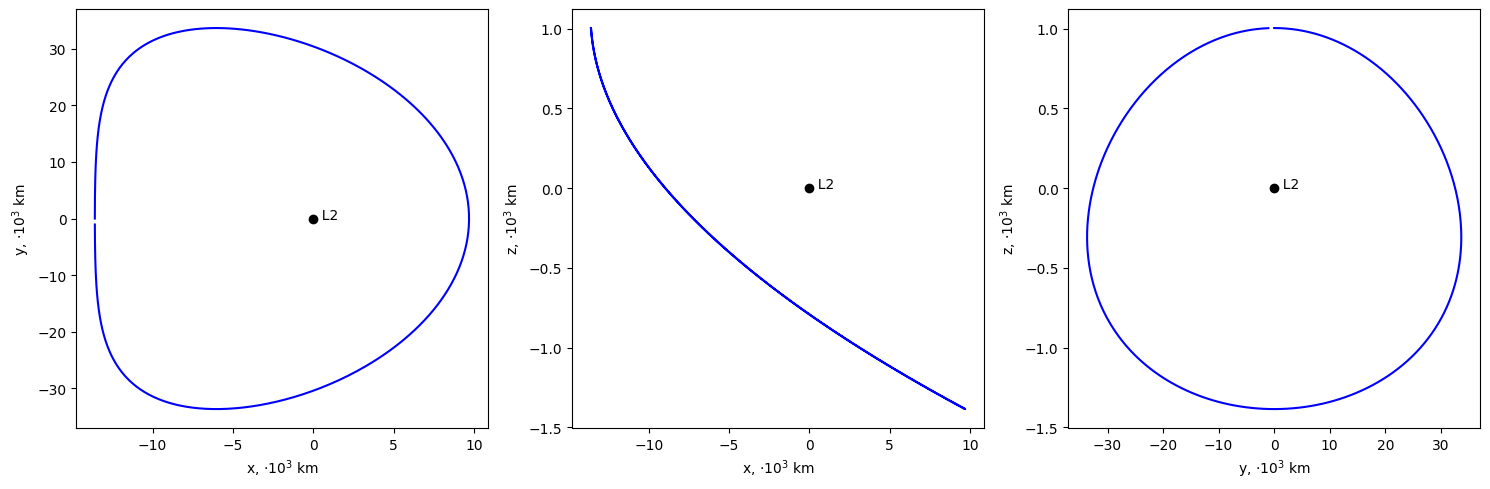

In [82]:
df = model.prop(zero_state, 0, 3.4)

plotter = op.plotter.from_model(model, length_units='Mm', velocity_units='km/s')
ax = plotter.plot_proj(df, centers={'x':model.L2})
plotter.plot_proj(ax=ax, centers={'x':model.L2}, plottables=[plotter.L2], colors='k',ls='',marker='o')


In [ ]:
first_correction = op.border_correction(model, op.y_direction(), left, right)
correction = op.border_correction(model, op.unstable_direction(model), left, right)
impulse_correction_method = op.simple_station_keeping(model, first_correction, correction, np.pi)

df = impulse_correction_method.prop(0.0, zero_state, N=int(50))
dv_norms = np.linalg.norm(impulse_correction_method.dvout[:,3:6], axis=1)
print(np.sum(dv_norms))

In [ ]:
plotter = op.plotter.from_model(model, length_units='Mm', velocity_units='km/s')
ax = plotter.plot_proj(df, centers={'x':model.L2})
plotter.plot_proj(ax=ax, centers={'x':model.L2}, plottables=[plotter.L2], colors='k',ls='',marker='o')

In [2]:
# =====================================
def get_dv_sum_for_dt(model, total_time, dt, initial_state):
    first_correction = op.border_correction(model, op.y_direction(), left, right)
    correction = op.border_correction(model, op.unstable_direction(model), left, right)
    impulse_correction_method = op.strict_station_keeping(model, first_correction, correction, dt, maxdv=1e2)
    
    df = impulse_correction_method.prop(0.0, initial_state, N=int(total_time // dt))
    dv_norms = np.linalg.norm(impulse_correction_method.dvout[:,3:6], axis=1)
    return [np.sum(dv_norms), dt], df
    

In [5]:
model = op.crtbp3_model('Earth-Moon (default)', integrator=op.dopri5_integrator(), stm=True)
halo_orbits = pd.read_csv(f'halo_general_low_l2.csv')

i = 300
zero_state = model.get_zero_state().copy()
zero_state[0] = halo_orbits.iloc[[i]]['x']
zero_state[2] = halo_orbits.iloc[[i]]['z']
zero_state[4] = halo_orbits.iloc[[i]]['v']
one_thousand_kms = (1-model.L1) / 61.350

left = op.eventX(model.L2 - 32 * one_thousand_kms)
right = op.eventX(model.L2 + 7 * one_thousand_kms)

total_time = 50*np.pi

dv_graph_data = []
# dts = [np.pi, np.pi/2, 1.3, np.pi/3, np.pi/4, np.pi/5, np.pi/6, np.pi/7, 0.45, np.pi/8, 0.35, np.pi/9, np.pi/10, np.pi/11]
# dts = np.linspace(np.pi/4, np.pi/8, 15)
dts = [np.pi/18, np.pi/22,  np.pi/26, np.pi/30]
print(dts)

for dt in dts:
    try:
        sum, _ = get_dv_sum_for_dt(model, total_time, dt, zero_state.copy())
    except (RuntimeError, ValueError) as e:
        print(e, sep=' ')  
        print("++++++ dt = " + str(dt) + " failed!")
        continue
    dv_graph_data.append(sum)
    print(sum)
    
print(dv_graph_data)
np.savetxt('dv_graph_data_5.txt',dv_graph_data)



/tmp/ipykernel_3360924/1054775706.py:6: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  zero_state[0] = halo_orbits.iloc[[i]]['x']
/tmp/ipykernel_3360924/1054775706.py:7: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  zero_state[2] = halo_orbits.iloc[[i]]['z']
/tmp/ipykernel_3360924/1054775706.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  zero_state[4] = halo_orbits.iloc[[i]]['v']


[0.17453292519943295, 0.14279966607226333, 0.1208304866765305, 0.10471975511965977]
Simple station-keeping: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 25

In [7]:
dv_graph_data_1 = np.loadtxt('dv_graph_data_4.txt')
dv_graph_data_2 = np.loadtxt('dv_graph_data_5.txt')
dv_graph_data = np.concatenate([dv_graph_data_1, dv_graph_data_2])

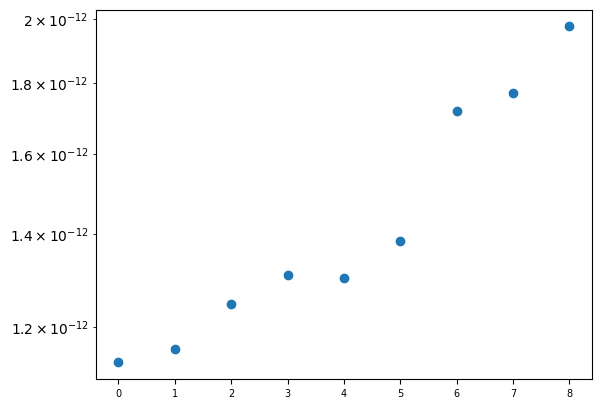

In [8]:
y_data = dv_graph_data[:,0]
x_data = np.arange(len(y_data))
x_ticks = dv_graph_data[:,1]
plt.xticks(x_data, fontsize=7)

plt.scatter(x_data, y_data)
plt.yscale('log')

In [11]:
x_data_ticks = np.loadtxt('x_data.txt')
x_ticks = np.load('x_ticks.npy')
y_data = np.loadtxt('y_data.txt')

y_data = np.concatenate([y_data, dv_graph_data[:,0]])
x_data_ticks = np.arange(len(y_data))
x_ticks = np.concatenate([x_ticks, np.array(['pi/12', 'pi/13', 'pi/14', 'pi/15', 'pi/16', 'pi/18', 'pi/22', 'pi/26', 'pi/30'])])



In [17]:
np.savetxt('x_data_1.txt', x_data_ticks)
np.save('x_ticks_1.npy', x_ticks)
np.savetxt('y_data_1.txt', y_data)

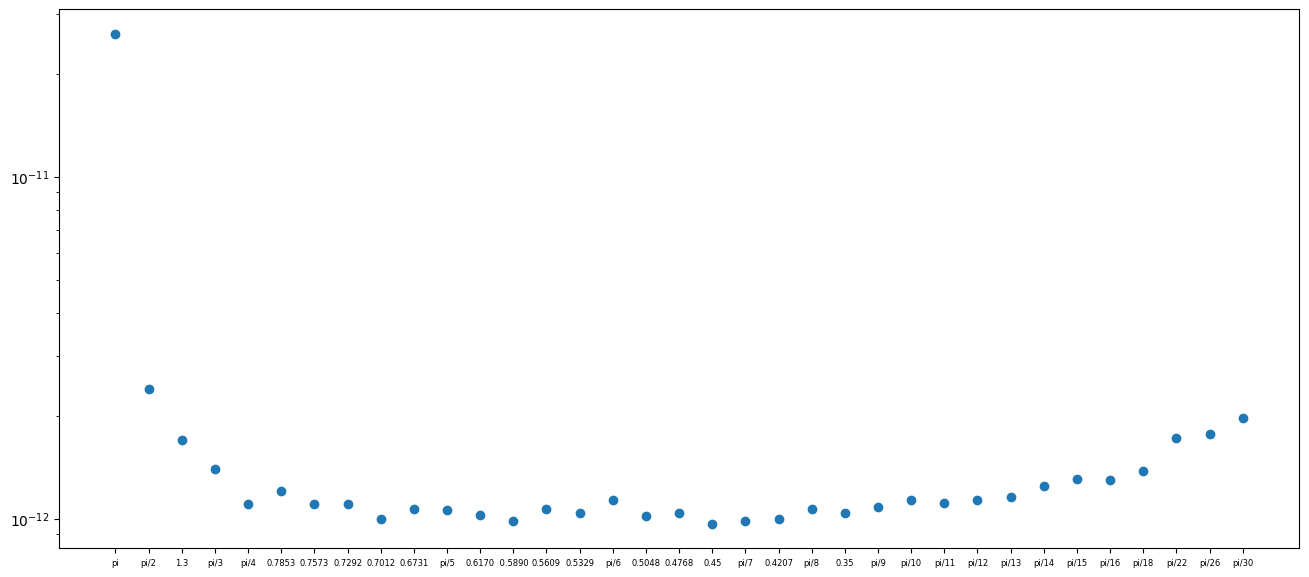

In [18]:
x_data_ticks = np.loadtxt('x_data_1.txt')
x_ticks = np.load('x_ticks_1.npy')
y_data = np.loadtxt('y_data_1.txt')

plt.figure(figsize=(16, 7))
plt.xticks(x_data_ticks, x_ticks, fontsize=6)

plt.scatter(x_data_ticks, y_data)
plt.yscale('log')
